In [1]:
# install the library that handles emoji
%pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from google.colab import drive
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/MyDrive/CS505 Datasets/final/'

In [5]:
df = pd.read_csv(data_path + 'cyberbullying_tweets.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [7]:
# rename the cloumns to facilitate following operations
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'labels'})

In [8]:
# remove duplicated tweets
df = df[~df.duplicated()]

In [9]:
# the dateset is almost balanced
df.labels.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: labels, dtype: int64

In [10]:
# convert emojis into their corresponding words
# emoji_text = "😊🚗🌺😷"
def emoji_to_words(text):
  text = emoji.demojize(text)
  return text

# print('Original: ', emoji_text)
# print('Translated: ', emoji_to_words(emoji_text))

In [11]:
def clean_tweets(text):
  # convert emojis to words
  text = emoji_to_words(text)
  # replace newline and carriage return with space, and convert to lowercase
  text = re.sub(r'\r|\n', ' ', text.lower())
  # replace links with space
  text = re.sub(r'http\S+|www\S+|https\S+', ' ', text).strip()
  # print(text)
  # remove hashtags and their contents at the end of the sentence
  prev_len = len(text)
  text = re.sub(r'#(\w+)$', '', text)
  length = len(text)
  while prev_len != length:
    prev_len = length
    text = re.sub(r'#(\S+)$', '', text).strip()
    length = len(text)
  # remove mentions and hashtags at the beginning of the sentence
  prev_len = len(text)
  text = re.sub(r'^@(\S+)', '', text)
  length = len(text)
  while prev_len != length:
    prev_len = length
    text = re.sub(r'^@(\S+)', '', text).strip()
    length = len(text)
  # print(text)
  # remove words containing non-ASCII characters
  text = re.sub(r'(\S*)[^\x00-\x7f](\S*)', '', text)
  # remove numbers
  text = re.sub(r'\d', '', text)
  # Replace elongated words with a single instance
  text = re.sub(r'(\w)\1{2,}', r'\1', text)
  # repalce punctuations with space
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  text = text.translate(translator).strip()
  # Lemmatize words
  lemmatizer = WordNetLemmatizer()
  words = word_tokenize(text)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  # remove stopwords
  text = ' '.join(word for word in lemmatized_words if word not in stop_words)
  return text

# # print(clean_tweets(emoji_to_words(emoji_text)))
# text = "In the past 12h, @spacekatgal is seeing the most targeted abuse, with 194 (36 OC/158 RT) GG hashtaged tweets mentioning her. Congrats!"
# print(clean_tweets(text))

In [12]:
df['cleaned_text'] = df['text'].apply(clean_tweets)

In [13]:
df.head()

,text,labels,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food wa crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks head concerned another angry dude...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [14]:
# remove texts that are too short
min_length = 4
df = df[df['cleaned_text'].str.len() >= 4]

In [18]:
# drop duplicated tweets
df = df.drop_duplicates("cleaned_text")

In [19]:
# The tweets that were mainly deleted were of the 'other_cyberbullying' type, making our dataset highly imbalanced. Therefore, we dropped tweets of this type.
df.labels.value_counts()

religion             7946
age                  7879
ethnicity            7767
gender               7608
not_cyberbullying    7551
Name: labels, dtype: int64

In [20]:
df = df[df["labels"]!="other_cyberbullying"]

In [21]:
df['text_len'] = [len(text.split()) for text in df.cleaned_text]

In [23]:
df.sort_values(by=['text_len'], ascending=False)

,text,labels,cleaned_text,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,193
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top anti bullying progr...,164
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb bitch lt whore smh think eithe...,163
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,142
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,132
...,...,...,...,...
2812,@reflexhouse what you gona do then? After all ...,not_cyberbullying,gona,1
3079,@TripleCeez004 woot,not_cyberbullying,woot,1
3078,@yeborskiy @deanofsurrey @Raqqa_Sl What is you...,not_cyberbullying,solution,1
6907,sociais,not_cyberbullying,sociais,1


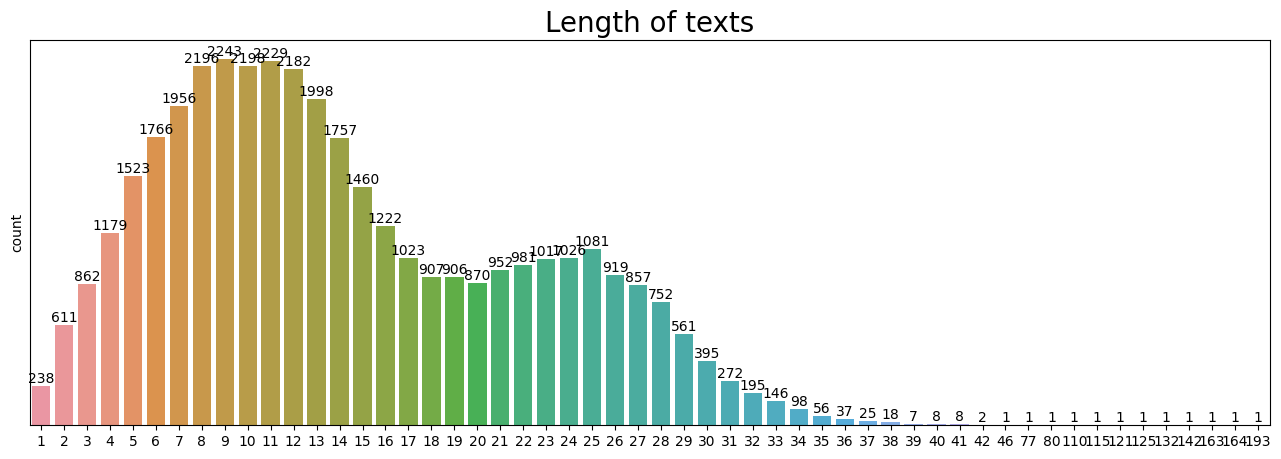

In [29]:
# show the length of all texts
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df)
plt.title('Length of texts', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [30]:
# remove the tweets that are too long
df = df[df['text_len'] <= 40]

In [31]:
df.to_csv(data_path + 'cleaned_data.csv', index=False)